## ***CE-672 Assignment - 06***
### **Amipriya Anand (220122)**

In [75]:
# import necessary libraries
import rasterio
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog, ttk
import matplotlib.pyplot as plt
from PIL import Image, ImageTk
import itertools
from skimage.transform import AffineTransform, warp

In [76]:
# crete function for linear contrast stretching
def contrast_stretch_linear(img, bit = 8):
    """
    function for Linear Contrast stretching 
    output: linearly contrast streched 8 bit (by defalut) image 
    """
    r_min, r_max = np.min(img),np.max(img)
    new_img  = (img - r_min)/(r_max-r_min) * (2**(bit) -1)
    return new_img

In [77]:
# for histogram equalisation
def Hist_equaliser(img,bit = 8):
    """
    Contrast stretching using Histogram equalisation
    output: Histogram equalised contrast streched 8 bit (by defalut) image 
    """
    hist, bins = np.histogram(img.flatten(), (2**(bit) -1))
    cdf = hist.cumsum()
    # normalise this cumulative sum 
    cdf_norm = cdf*(2**(bit) -1)/cdf[-1]              # this scales it from 0 to 255
    equlaised = np.interp(img.flatten(),bins[:-1],cdf_norm)
    return equlaised.reshape(img.shape).astype(np.uint8)


In [78]:
# for Gaussian Contrast Stretching
def Gauss_stretch(img, k = 2,bit = 8):
    """
    Contrast stretching using the Gaussian Stretching
    Assumption: pixel intensity is assumed to be following Gaussian Distribution
    define ranges
      r_min = mu-k*sigma
      r_max = mu+k*sigma
    apply linear stretch from r_min to r_max and clip all values falling outside this range
    output: Gaussian contrast streched 8 bit (by defalut) image 
    """
    mu = np.mean(img)
    std = np.std(img)
    r_min = mu - k*std
    r_max = mu + k*std
    # generate new image
    new_img  = (img - r_min)/(r_max-r_min) * (2**(bit) -1)
    # Clip values to [0,255]
    new_img[img < r_min] = 0
    new_img[img > r_max] = (2**(bit) -1)
    return np.clip(new_img, 0, (2**(bit) -1)).astype(np.uint8)

size of B1IRS.IMG: (512, 512)
size of B2IRS.IMG: (512, 512)
size of B3IRS.IMG: (512, 512)
size of B4IRS.IMG: (512, 512)
size of LUKPAN.IMG: (1024, 1024)
size of FCCIRS.IMG: (512, 512)


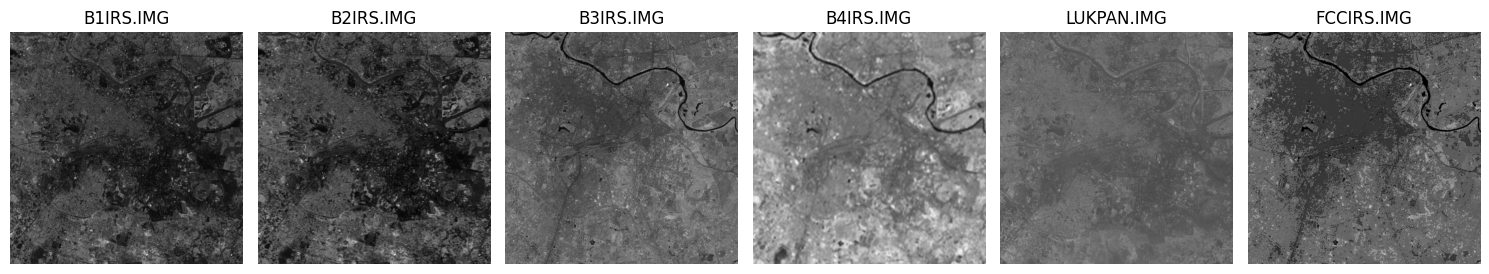

In [79]:
# writting a function that stores all the image in an array data structure
def load_image(file_arr):
    """
    stores and return array of image in same order as given in file path array
    """
    # define arr to store image
    loaded_img_arr = []
    
    for file in file_arr:
        # read the file 
        with open(file,"rb") as src:
            # convert to unsigned int 8 bit
            img = np.fromfile(src, dtype=np.uint8)
            # reshape the image file as stored img is 1D array convert to 2D square array
            size = int(np.sqrt(len(img)))
            loaded_img_arr.append(img.reshape(size, size))
    return loaded_img_arr

# create file path array
file_path_arr = ['B1IRS.IMG','B2IRS.IMG','B3IRS.IMG','B4IRS.IMG','LUKPAN.IMG','FCCIRS.IMG']

# generate image array corresponding to file path array
selected_image = load_image(file_path_arr)
# check the size of each image:
for i in range(len(file_path_arr)):
    print(f"size of {file_path_arr[i]}: {selected_image[i].shape}")

# display each of the image:
plt.figure(figsize=(15,10))
for i in range(len(file_path_arr)):
    plt.subplot(1,len(file_path_arr),i+1)
    plt.imshow(selected_image[i], cmap="gray")
    plt.axis("off")
    plt.title(f"{file_path_arr[i]}")

plt.tight_layout()
plt.show()

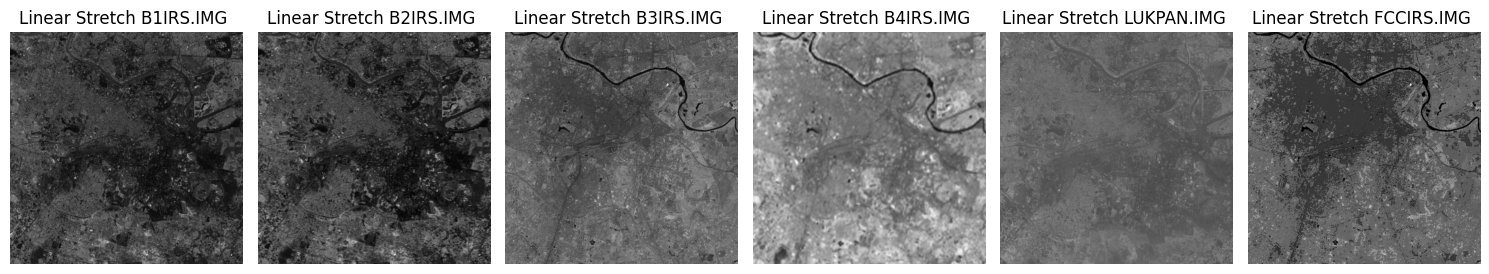

In [80]:
# display all images obtained after linear contrast strecting 
plt.figure(figsize=(15,20))
for i in range(len(file_path_arr)):
    plt.subplot(1,len(file_path_arr),i+1)
    new_img = contrast_stretch_linear(selected_image[i])
    plt.imshow(new_img, cmap="gray")
    plt.axis("off")
    plt.title(f"Linear Stretch {file_path_arr[i]} ")

plt.tight_layout()
plt.show()

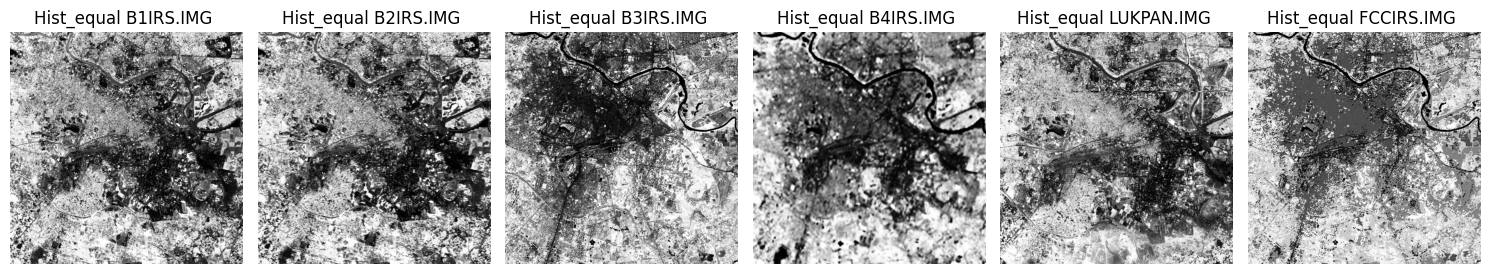

In [81]:
# display all images obtained after Histogram Equalistaion 
plt.figure(figsize=(15,20))
for i in range(len(file_path_arr)):
    plt.subplot(1,len(file_path_arr),i+1)
    new_img = Hist_equaliser(selected_image[i])
    plt.imshow(new_img, cmap="gray")
    plt.axis("off")
    plt.title(f"Hist_equal {file_path_arr[i]} ")

plt.tight_layout()
plt.show()

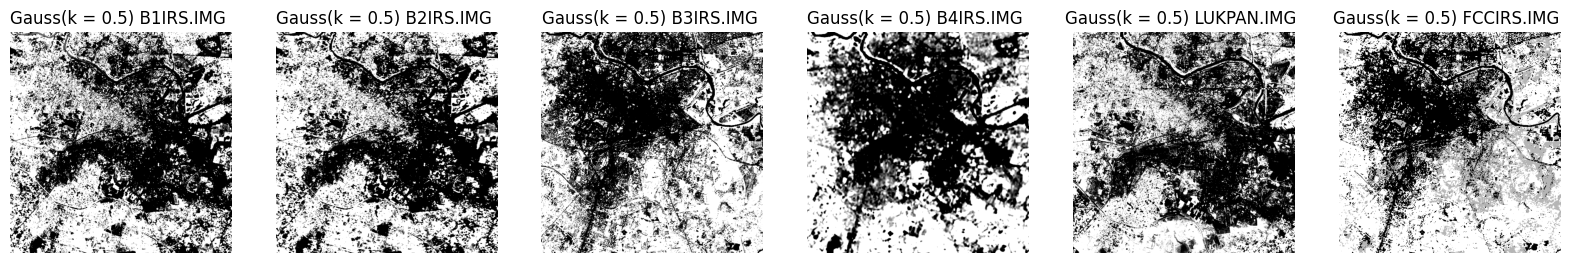

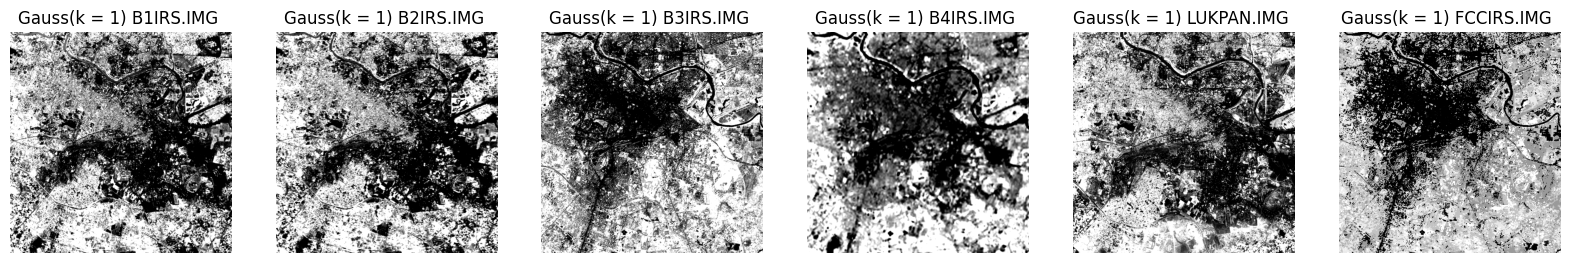

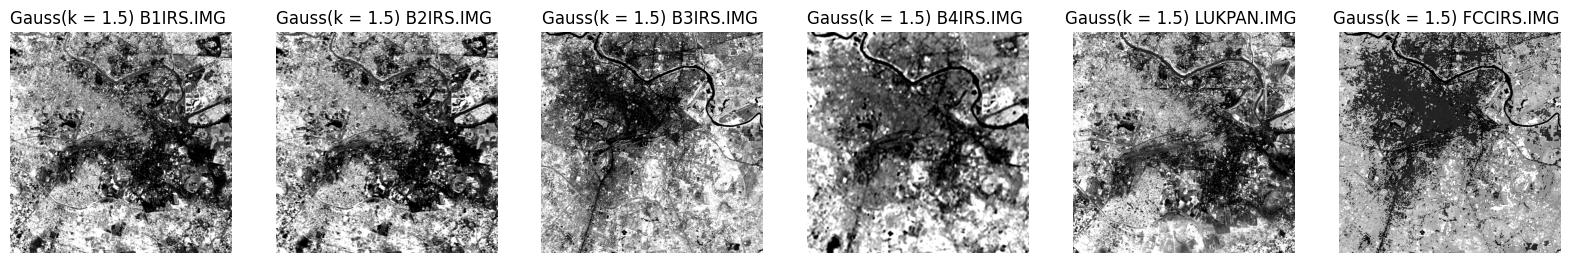

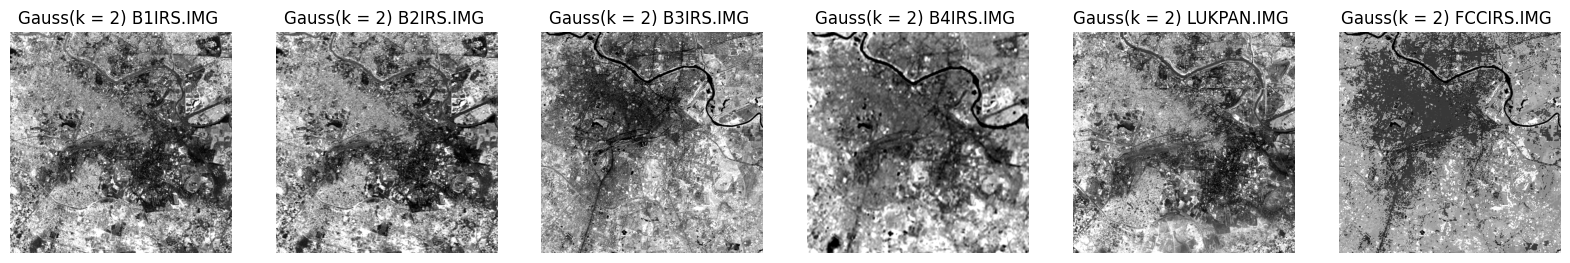

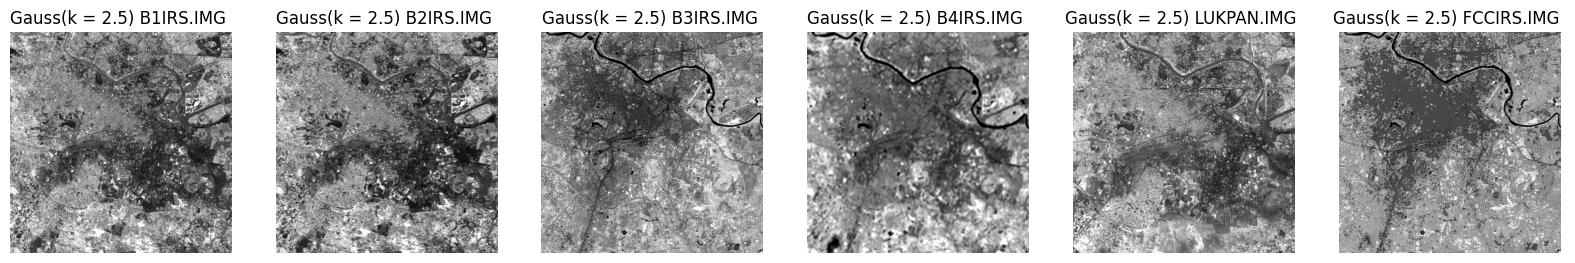

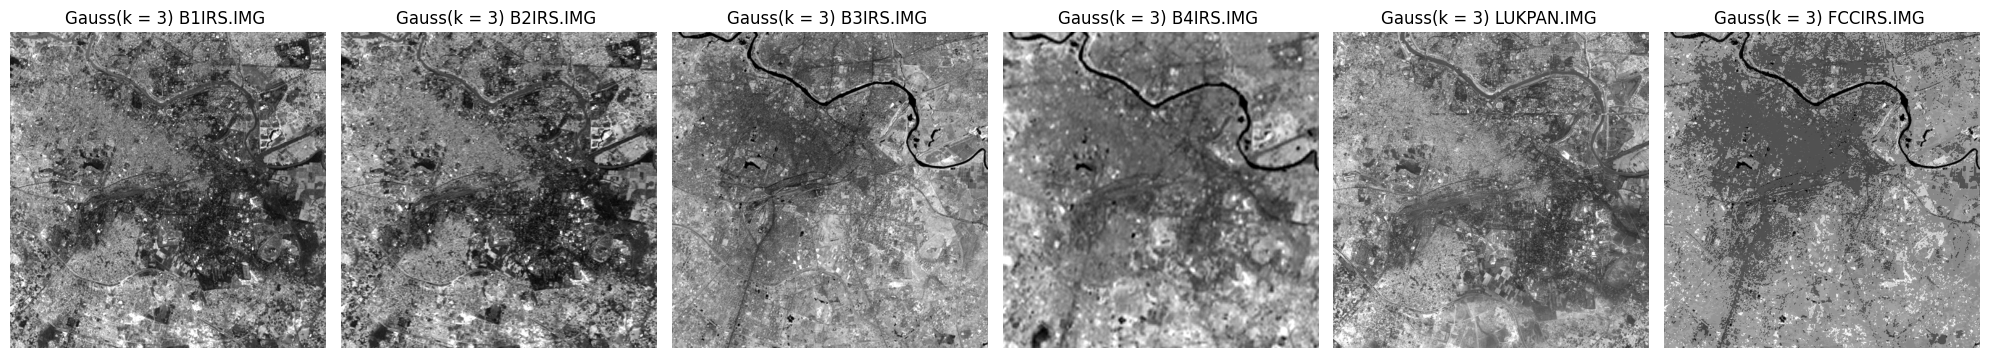

In [82]:
# display all images obtained after Gaussian contrast strecting 
k_val = [0.5,1,1.5,2,2.5,3]
for j in range(len(k_val)):
    plt.figure(figsize=(20,20))
    for i in range(len(file_path_arr)):
        plt.subplot(1,len(file_path_arr),i+1)
        new_img = Gauss_stretch(selected_image[i],k =k_val[j])
        plt.imshow(new_img, cmap="gray")
        plt.axis("off")
        plt.title(f"Gauss(k = {k_val[j]}) {file_path_arr[i]} ")
plt.tight_layout()
plt.show()

#### **Creating a simple GUI**

In [83]:
# created a simple gui that takes image as well as image doc as input  
def read_metadata(doc_path):
    """
    Reads metadata from the .DOC file and returns a dictionary of values.
    Expected keys: "rows", "columns", "data type", etc.
    """
    try:
        with open(doc_path, 'r') as doc_file:
            metadata = {}
            for line in doc_file:
                parts = line.strip().split(':')
                if len(parts) == 2:
                    key, value = parts[0].strip(), parts[1].strip()
                    metadata[key] = value
            return metadata
    except Exception as e:
        messagebox.showerror("Error", f"Failed to read metadata: {e}")
        return None

def load_img_file_np(img_path, metadata):
    """
    Loads the .IMG file using NumPy based on metadata dimensions.
    Expects metadata to include: "rows", "columns", and "data type".
    """
    try:
        rows = int(metadata.get("rows", 512))
        cols = int(metadata.get("columns", 512))
        dtype = np.uint8 if metadata.get("data type", "").lower() == "byte" else np.float32
        
        with open(img_path, 'rb') as img_file:
            data = np.fromfile(img_file, dtype=dtype)
            image = data.reshape((rows, cols))
        return image
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load .IMG file: {e}")
        return None

def display_image(image, title="Image"):
    """
    Displays a given image in a new Toplevel window.
    """
    # Convert NumPy array to PIL Image
    pil_img = Image.fromarray(image)
    img_tk = ImageTk.PhotoImage(pil_img)
    top = tk.Toplevel()
    top.title(title)
    label = tk.Label(top, image=img_tk)
    label.image = img_tk  # Keep reference to avoid garbage collection
    label.pack()

In [84]:
# GUI: Main Function
def main_gui():
    global root
    root = tk.Tk()
    root.title("My(220122) Contrast Stretching GUI")
    root.geometry("400x300")
    
    # Global variables to hold the loaded and transformed images
    root.loaded_image = None
    root.transformed_image = None
    
    # Callback: Load image using NumPy based on metadata from .DOC file
    def load_and_display_image():
        img_path = filedialog.askopenfilename(title="Select .IMG File", filetypes=[("IMG Files", "*.IMG")])
        doc_path = filedialog.askopenfilename(title="Select Metadata File (.DOC)", filetypes=[("DOC Files", "*.DOC")])
        
        if not img_path or not doc_path:
            messagebox.showerror("Error", "Both .IMG and .DOC files must be selected!")
            return
        
        metadata = read_metadata(doc_path)
        if metadata is None:
            return
        
        loaded = load_img_file_np(img_path, metadata)
        if loaded is not None:
            root.loaded_image = loaded
            display_image(loaded, title="Original Image")
    
    # Callback: Apply Contrast Stretching
    def apply_transformation():
        if root.loaded_image is None:
            messagebox.showerror("Error", "No image loaded!")
            return
        try:
            bit = int(entry_bit.get())
            k = float(entry_k.get())
            Contrast_method = contrast_var.get()
            if Contrast_method == "Linear Contrast Stretch":
                transformed = contrast_stretch_linear(root.loaded_image,bit)
            elif Contrast_method == "Histogram Equalistaion":
                transformed = Hist_equaliser(root.loaded_image,bit)
            elif Contrast_method == "Gaussina Contrast Stretch":
                transformed = Gauss_stretch(root.loaded_image, k, bit)
            else:
                transformed = contrast_stretch_linear(root.loaded_image,bit)

            root.transformed_image = transformed
            display_image(transformed, title=f"{Contrast_method} Image output in {bit} bit")
        except ValueError as ve:
            messagebox.showerror("Error", f"Invalid input: {ve}")
    
    # Callback: Save transformed image
    def save_transformed():
        if root.transformed_image is None:
            messagebox.showerror("Error", "No transformed image to save!")
            return
        save_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG Files", "*.png"), ("JPEG Files", "*.jpg")])
        if save_path:
            try:
                Image.fromarray(root.transformed_image.astype(np.uint8)).save(save_path)
                messagebox.showinfo("Saved", f"Image saved to {save_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to save image: {e}")
    
    # Build GUI Layout:
    # Row 0: Load Image Button
    tk.Button(root, text="Load .IMG and Metadata (.DOC)", command=load_and_display_image).grid(row=0, column=0, columnspan=2, pady=10,padx=10)
    
    # Row 1: Output image (noramlise to x bit) x = 8(by default) 
    tk.Label(root, text="bit of image:").grid(row=1, column=0, sticky="e")
    entry_bit = tk.Entry(root, width=10)
    entry_bit.insert(8, "8")
    entry_bit.grid(row=1, column=1, pady=5,padx=10)
    
    # Row 2: k value (for Gaussian Contrast stretching)
    tk.Label(root, text="k (for Gaussian stretching):").grid(row=2, column=0, sticky="e")
    entry_k = tk.Entry(root, width=10)
    entry_k.insert(2, "2")
    entry_k.grid(row=2, column=1, pady=5,padx=10)
    
    # Row 3: Contrast Stretching Technique 
    tk.Label(root, text="Method:").grid(row=3, column=0, sticky="e")
    contrast_var = tk.StringVar(value="Linear Contrast Stretch")
    contrast_dropdown = ttk.Combobox(root, textvariable=contrast_var, values=["Linear Contrast Stretch", "Histogram Equalistaion", "Gaussina Contrast Stretch"], state="readonly", width=25)
    contrast_dropdown.grid(row=3, column=1, pady=5,padx=10)
    
    # Row 4: Action Buttons (Apply Transformation, Save)
    tk.Button(root, text="Apply Contrast Stretching", command=apply_transformation).grid(row=4, column=0, pady=10,padx=10)
    tk.Button(root, text="Save Transformed Image", command=save_transformed).grid(row=4, column=1, pady=10,padx=10)
    
    root.mainloop()

if __name__ == "__main__":
    main_gui()
